In [1]:
## SETUP ##
import time
import os
from random import randint
import pandas as pd
import numpy as np
import timeit
from datetime import datetime, timedelta
from pytrends.request import TrendReq
from itertools import chain
import seaborn as sns
import string
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

# DLM 

In [2]:
import pydlm
import matplotlib.pyplot as plt
import pydlm.plot.dlmPlot as dlmPlot
from pydlm import dlm, trend, seasonality
from pydlm import dynamic

In [4]:
# import vix data
vix_data = pd.read_csv('/Users/mueric35/Desktop/Sentiment-and-Marktet-Analysis/GTdata/VIX.csv')

In [5]:
# turn str into date 
vix_data['Date'] = vix_data['Date'].apply(lambda x : datetime.strptime(x,'%m/%d/%y').date())

In [6]:
# select time frame
vix_model_data = vix_data[(vix_data['Date'] > datetime(2013,1,27).date() )&(vix_data['Date'] < datetime(2018,1,21).date() ) ]


In [7]:
# create week dataframe for merge 
week_day = [datetime(2018,1,21).date()]
end_date = datetime(2018,1,21).date()
while  end_date > datetime(2013,1,28).date():
    week_day.append(end_date - timedelta(days = 1))
    end_date = end_date - timedelta(days = 1)
last_full_week = np.floor(len(week_day)/7).astype(int)
mod = len(week_day)%7
rg = list(range(1,last_full_week+1))
week = np.repeat(rg,7).tolist() + [last_full_week] * mod
week_df = pd.DataFrame({'Date' : week_day[::-1], 'week'  : week})

In [8]:
# merge 
vix_model_data = pd.merge(vix_model_data,week_df,how = 'left')

In [9]:
# weekly average Close 
week_mean_close = vix_model_data.groupby('week')['Close'].mean()

In [10]:
# import google trend cdv data

In [12]:
df = pd.read_csv('/Users/mueric35/Desktop/Sentiment-and-Marktet-Analysis/GTdata/df_all.csv', index_col= 0)

In [13]:
# match the time frame with vix, delete last row
df.drop(df.index[259],inplace= True)


## Univariate DLM for EDA

#### Model cluster 1 from exploratory data analysis

##### Cluster 1: "boom.town" ,"old.colony.memorial" ,"thrifty.nickel" ,"reactionary"  ,"black.gold" ,"inflation.definition","bums"                

In [14]:
# Independence Variable

ts = week_mean_close.tolist() #vix
#ts = np.array(df.iloc[:,0])


In [15]:
# dependence variable
df_features = df.iloc[:,[i -1 for i in [25,103,195,197,273,275]]]
features_ls = []
for i in range(0,df_features.shape[0]):
    features_ls.append(np.array(df_features.iloc[i,:5]).tolist())

In [16]:
features = features_ls

In [708]:
# model setting

# A linear trend
linear_trend = trend(degree = 1, discount=0.99, name='linear_trend', w=10)
# A seasonality
seasonal52 = seasonality(period=7, discount=0.99, name='seasonal52', w=10)
# Regressor 
regressor10 = dynamic(features=features, discount= 0.95, name='regressor10', w=100)

# Autoregression
auto3 = pydlm.autoReg(degree=3, data = ts)

drm = dlm(ts) + linear_trend + seasonal52 + regressor10 + auto3
drm.fit()




Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


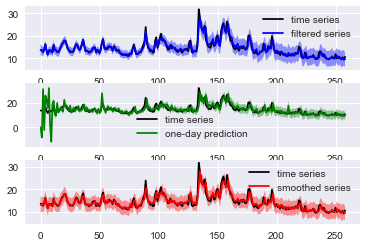

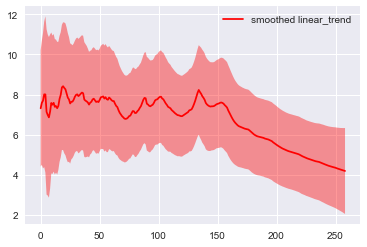

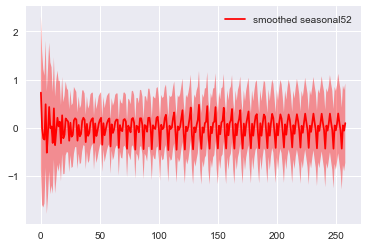

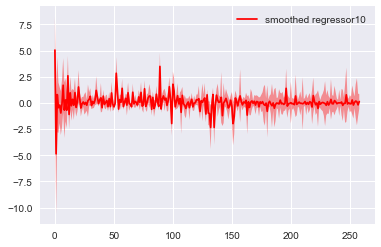

In [709]:
# Plot the fitted results
drm.turnOff('data points')
drm.plot()
# Plot each component (attribution)
drm.turnOff('predict plot')
drm.turnOff('filtered plot')
drm.plot('linear_trend')
drm.plot('seasonal52')
drm.plot('regressor10')

In [710]:
def plot_smooth(component, p = 0.95 ):
    
    from scipy.stats import norm

    reg_state = drm.getLatentState('backwardSmoother',component)
    cov_mat = drm.getLatentCov(filterType='backwardSmoother', name= component)



    higher = []
    lower = []
    for i in range(len(cov_mat)):

        reg_1 = reg_state[i]
        var = np.diag(cov_mat[i])
        scale = norm.ppf(1-(1-p)/2)

        # create bount
        higher.append(reg_1 + np.sqrt(var) * scale)
        lower.append(reg_1 - np.sqrt(var) * scale)

    higher = np.matrix(higher)
    lower = np.matrix(lower)
    reg_state = np.matrix(reg_state)

    for i in range(higher.shape[1]):
        fig, ax = plt.subplots(figsize=(40,8))
        ax.fill_between(range(len(np.array(higher[:,i]))),
                        np.array(higher[:,i]).flatten().tolist(), 
                        np.array(lower[:,i]).flatten().tolist(), color='lightgray', alpha=0.5)
        ax.plot(reg_state[:,i])
        topic = 'Smoothed result for ' + 'Component' + ' ' + str(i) + ' in ' + component + ':'
        ax.set_title(str(topic), fontsize = 30)
        ax.tick_params(labelsize=20)

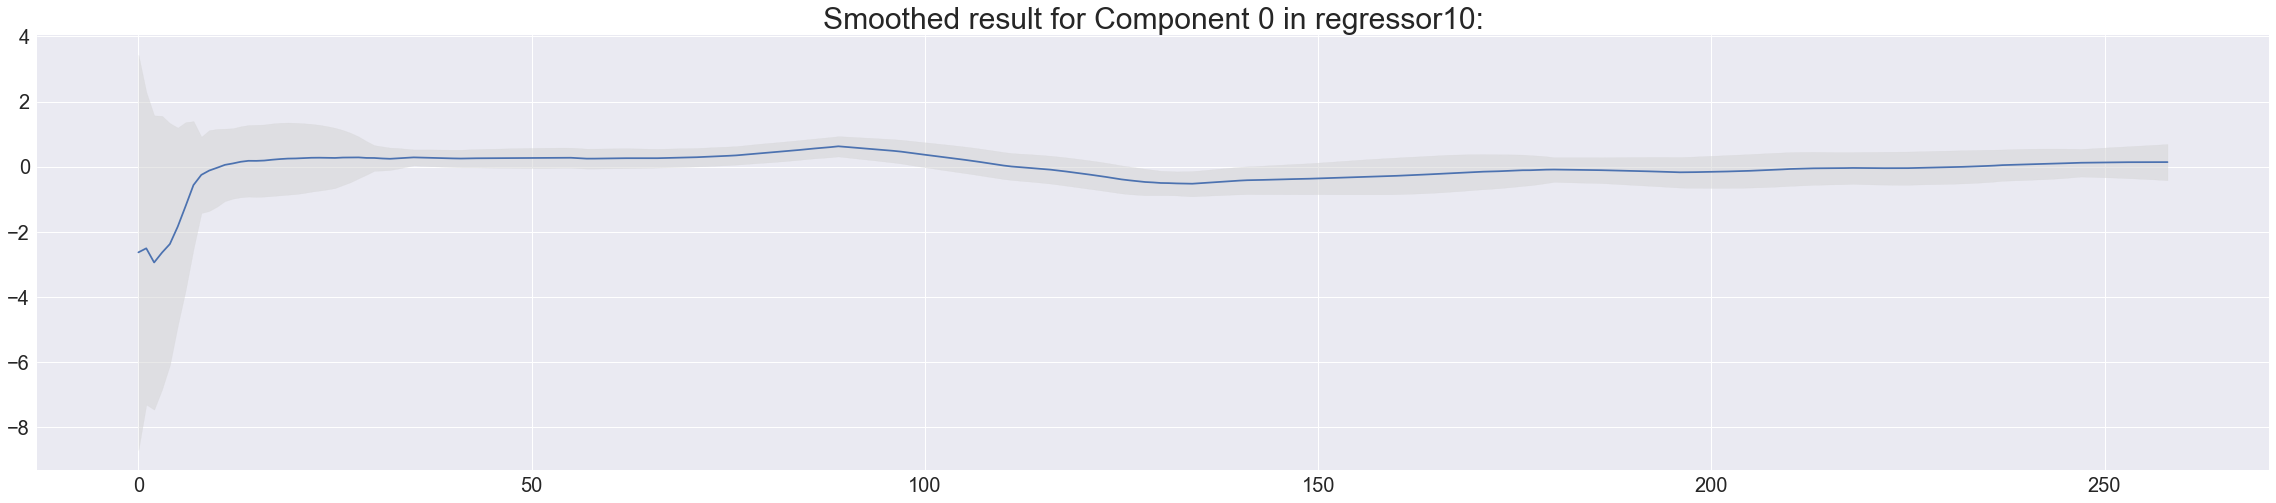

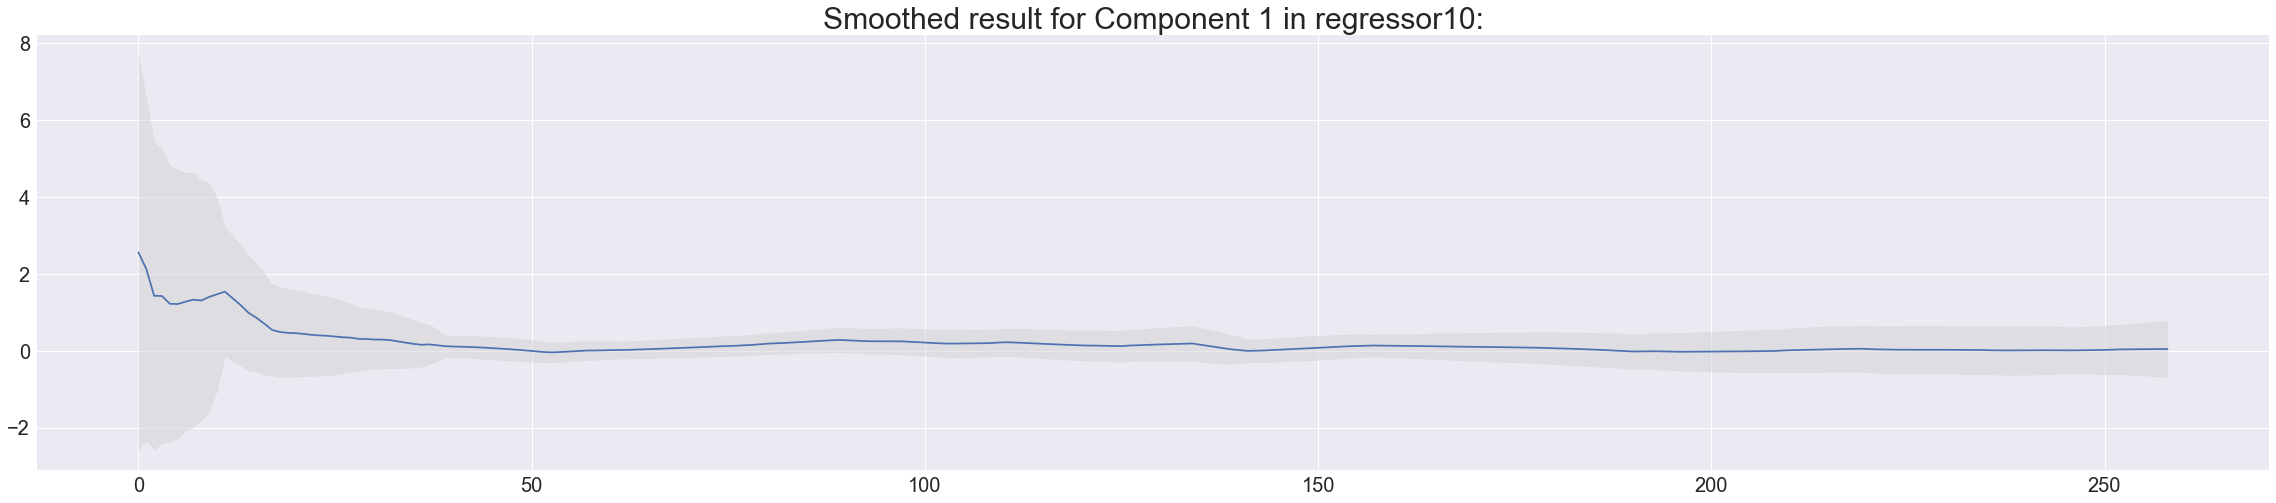

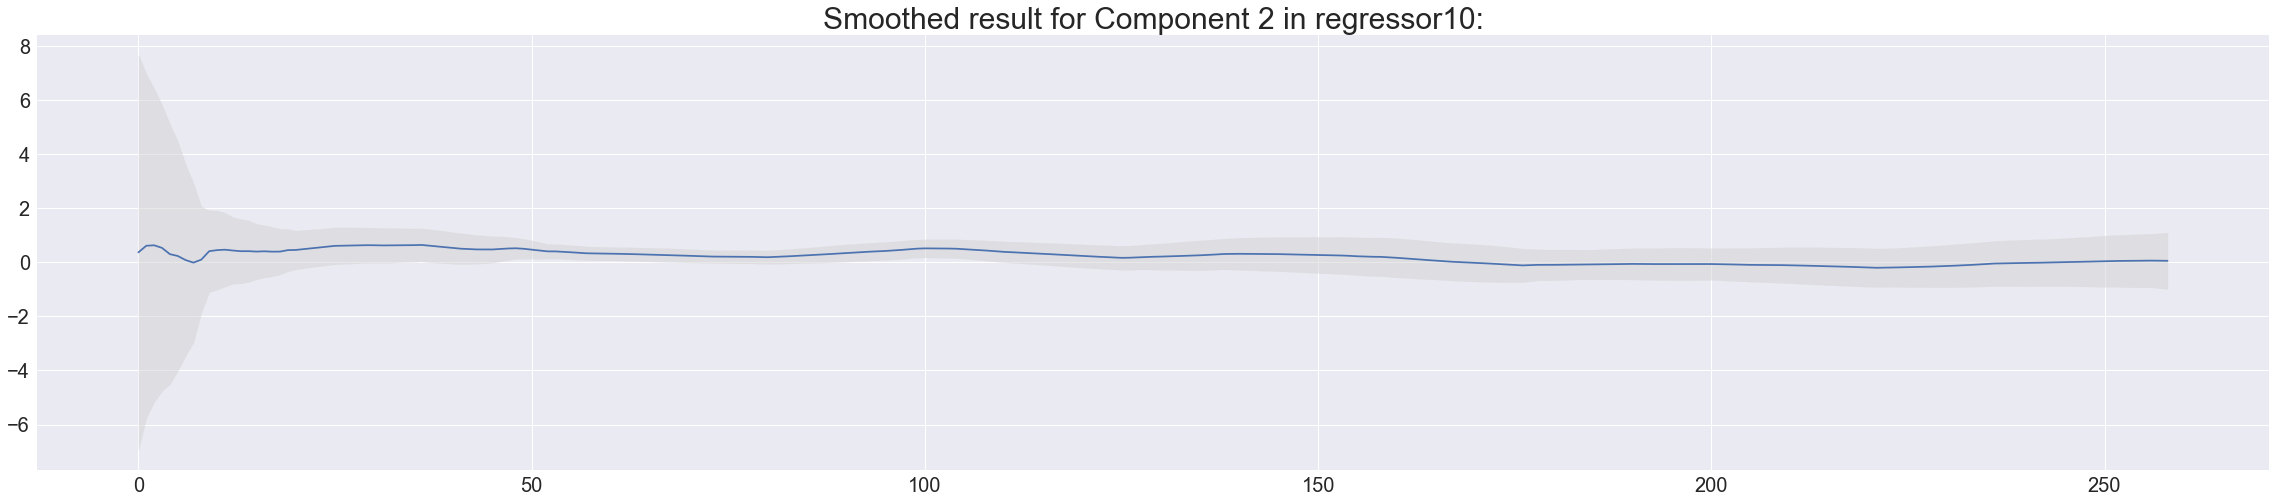

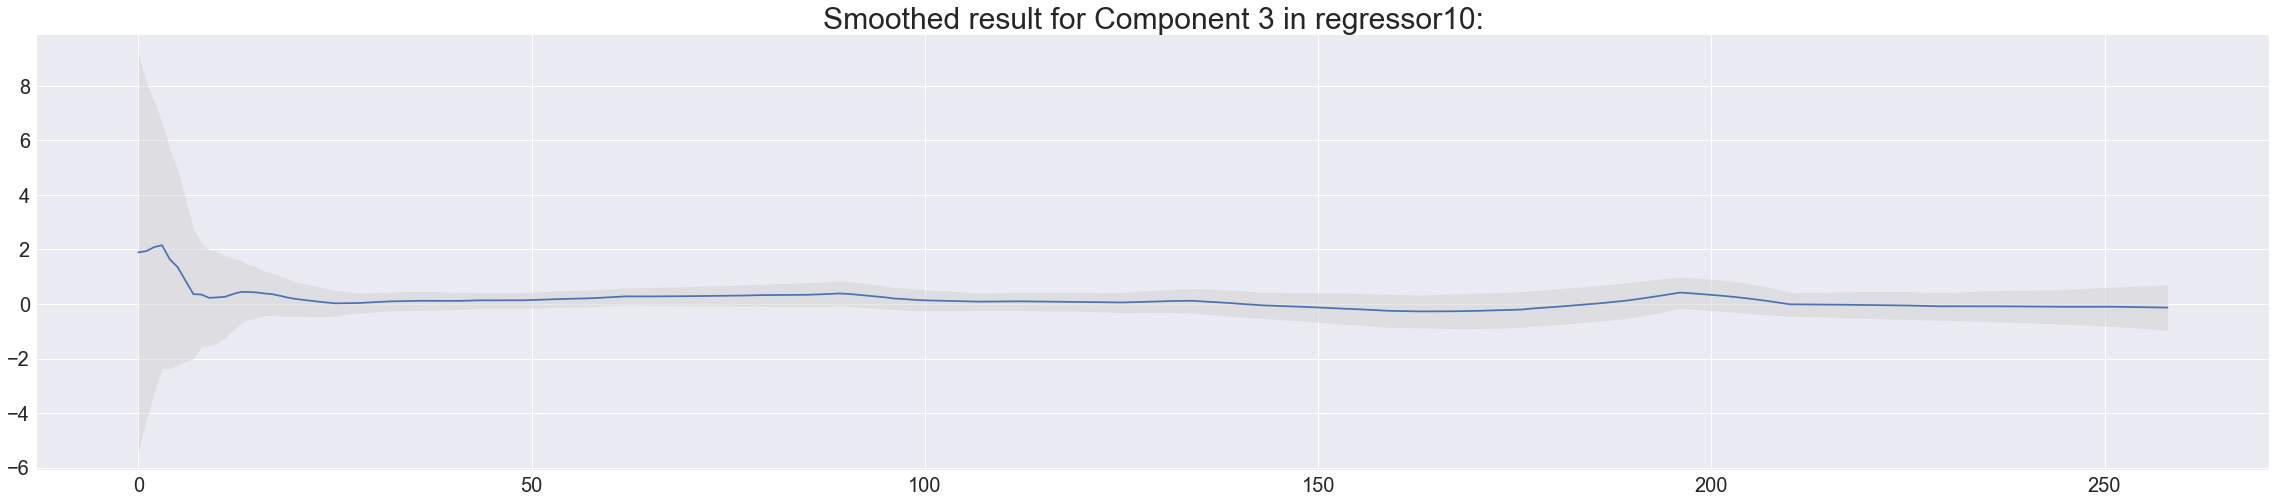

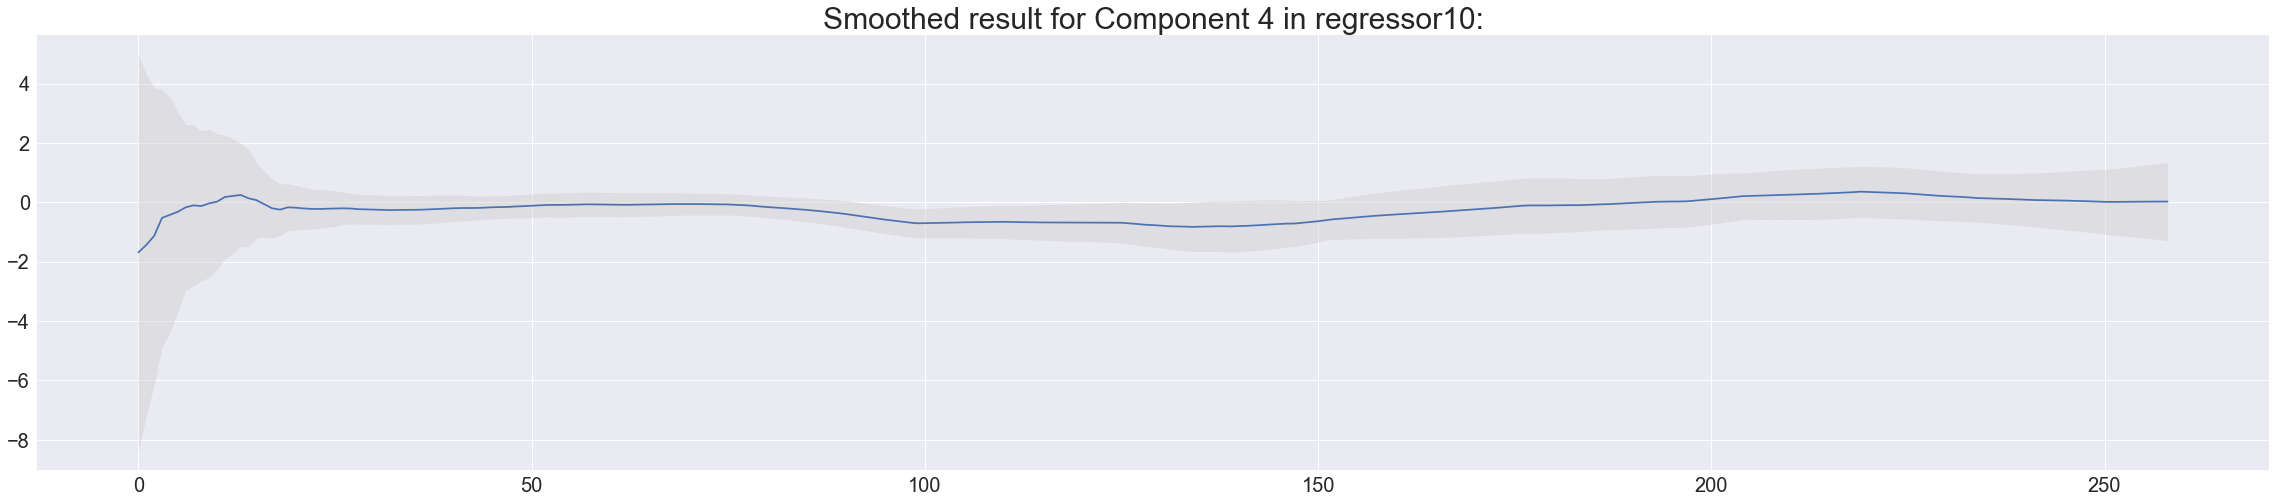

In [711]:
plot_smooth('regressor10',0.95)


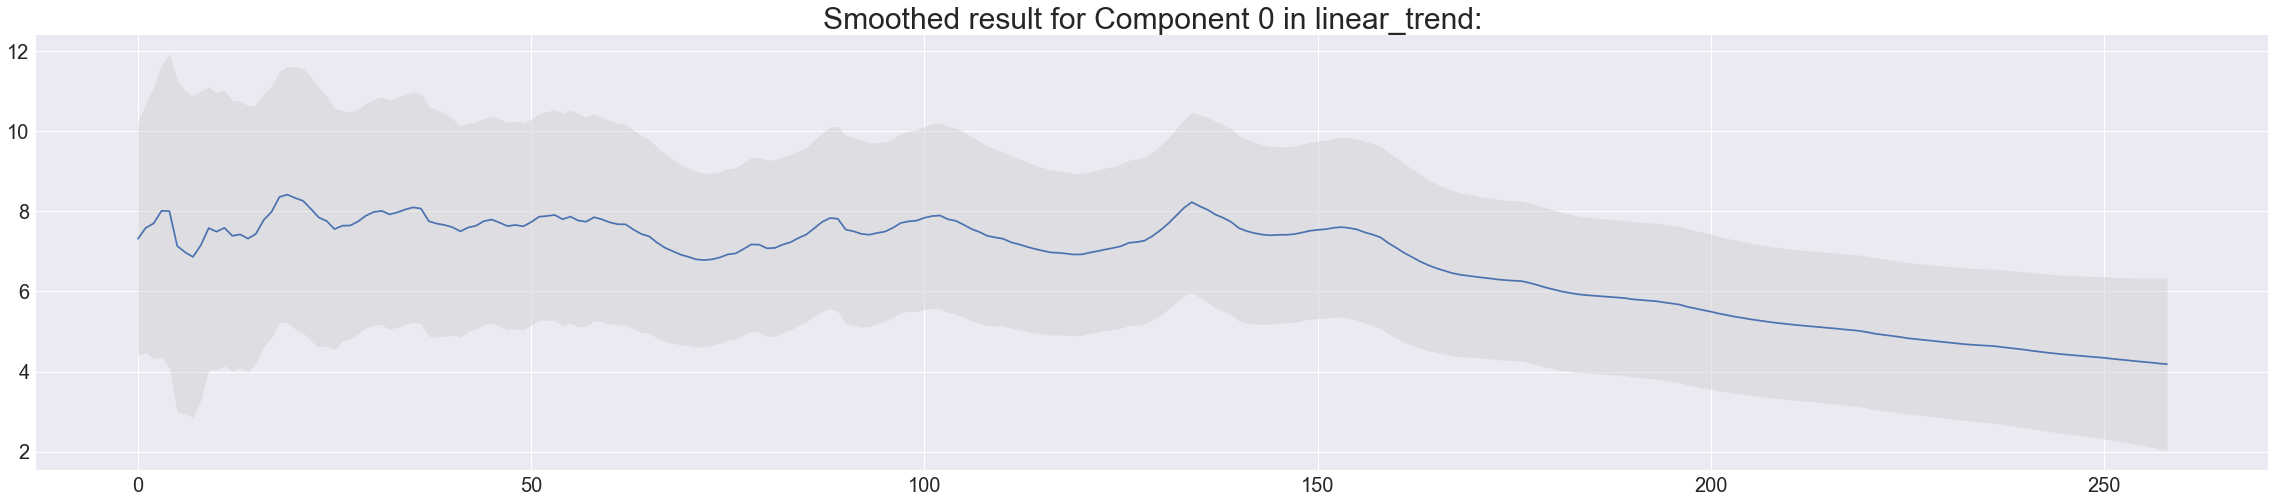

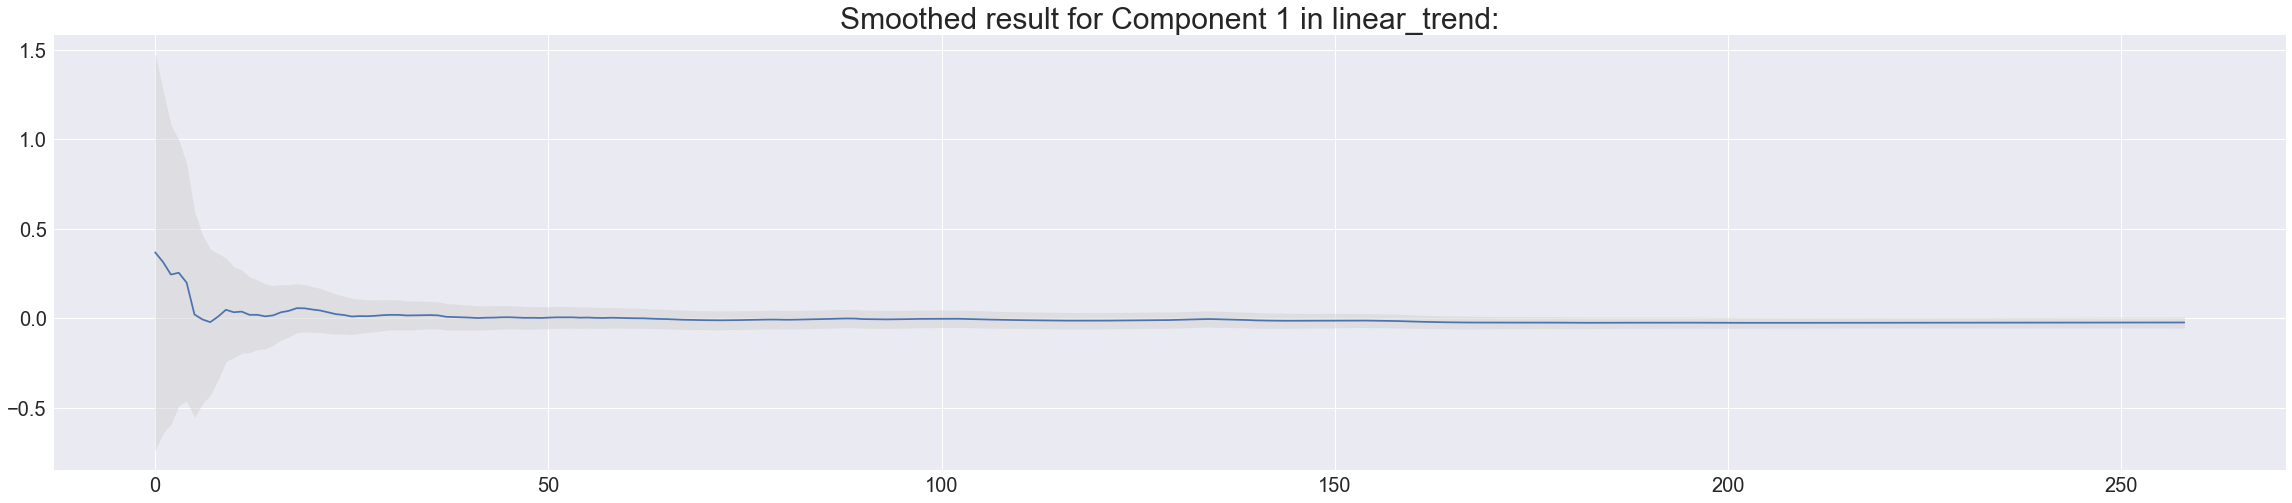

In [712]:
plot_smooth('linear_trend',0.95)


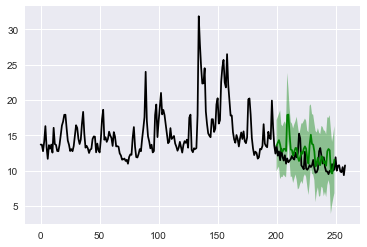

In [716]:
# Plot the prediction give the first 250 weeks and forcast the next 200 weeks.
a = drm.plotPredictN(N=50, date=200)